In [1]:
import pandas as pd
import numpy as np
import sqlite3

# Chargement des donnees

In [20]:
clean = '../../datas/CLEAN/E2/'

con = sqlite3.connect(clean + 'E2.db')
df = pd.read_sql('select * from clean_data', con, index_col='index')

con.close()

df[df.columns[:16]].head(5)

,order_item_id,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state,seller_city,seller_state,weight,volume
index,,,,,,,,,,,,,,,,
0,1,2018-03-26 23:31:39,19.5,8.290000,delivered,2018-03-20 23:22:32,2018-03-20 23:35:35,2018-03-21 20:32:23,2018-03-28 13:06:40,2018-04-02 00:00:00,sao paulo,SP,sao paulo,SP,500.0,2057.0
1,1,2018-03-27 02:56:23,412.0,26.200001,delivered,2018-03-20 15:08:17,2018-03-21 02:56:23,2018-03-21 21:05:05,2018-04-02 23:32:55,2018-04-24 00:00:00,rio de janeiro,RJ,curitiba,PR,3000.0,18000.0
2,1,2018-03-01 02:35:49,412.0,17.090000,delivered,2018-02-23 15:00:35,2018-02-24 02:35:49,2018-02-26 19:55:39,2018-02-27 20:04:41,2018-03-09 00:00:00,curitiba,PR,curitiba,PR,3000.0,18000.0
3,1,2018-02-06 14:21:20,412.0,27.719999,delivered,2018-01-31 11:48:43,2018-01-31 14:21:20,2018-02-06 22:57:38,2018-02-20 18:44:57,2018-03-01 00:00:00,matao,SP,curitiba,PR,3000.0,18000.0
4,1,2018-01-23 17:50:48,412.0,27.719999,delivered,2018-01-17 17:34:42,2018-01-17 17:50:48,2018-01-19 18:32:14,2018-01-31 19:22:56,2018-02-14 00:00:00,amparo,SP,curitiba,PR,3000.0,18000.0


# Calcul des differentes distances

In [22]:
for col in df.columns[5:10]:
    df[col] = pd.to_datetime(df[col])

df[df.columns[5:10]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108636 entries, 0 to 108635
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_purchase_timestamp       108636 non-null  datetime64[ns]
 1   order_approved_at              108636 non-null  datetime64[ns]
 2   order_delivered_carrier_date   108636 non-null  datetime64[ns]
 3   order_delivered_customer_date  108636 non-null  datetime64[ns]
 4   order_estimated_delivery_date  108636 non-null  datetime64[ns]
dtypes: datetime64[ns](5)
memory usage: 5.0 MB


In [52]:
temp = df.iloc[0:4]

target = pd.Series(
    [
        (end - start).total_seconds()/60/60/24
        for end, start in df[['order_delivered_customer_date', 'order_purchase_timestamp']].itertuples(index=False)
    ]
)

target.describe()

count    108636.000000
mean         12.467263
std           9.434257
min           0.533414
25%           6.734311
50%          10.182257
75%          15.532130
max         209.628611
dtype: float64

<AxesSubplot:>

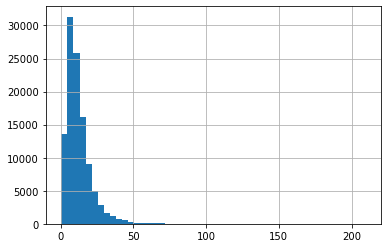

In [58]:
target.hist(bins=50)

In [61]:
target.describe()

count    108636.000000
mean         12.467263
std           9.434257
min           0.533414
25%           6.734311
50%          10.182257
75%          15.532130
max         209.628611
dtype: float64

In [56]:
from scipy.stats import zscore
clean_target = target[np.abs(zscore(target)) < 3]
clean_target

0          7.572315
1         13.350440
2          4.211181
3         20.289051
4         14.075162
            ...    
108630    22.748738
108631     4.349606
108632    18.109225
108633    16.048403
108634     7.671574
Length: 106822, dtype: float64

<AxesSubplot:>

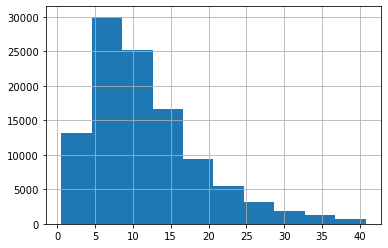

In [57]:
clean_target.hist()